In [33]:
# 其实是用前12个月的数据，预测后12个月的数据，中间的11个月是重合的，
# 所以只有最后一个月的数据是有用的，是预测出来的。
# 这个预测出来的数据，又被feedback到原来的数据里面去，接着做预测
# tf v1.0玩法

# 1. 根据时序数据预测一头牛每个月产多少牛奶

# 引入库和读入数据
# index_col = 'Month'
# Month列做index

# import the necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
# Read the dataset and print the head of it
milk = pd.read_csv('./monthly-milk-production-pounds-p.csv', index_col='Month')
milk.head()

,Monthly milk production (pounds per cow)
Month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


In [35]:
# 可视化数据

# 3. Convert the index to time series
milk.index = pd.to_datetime(milk.index)

<Axes: xlabel='Month'>

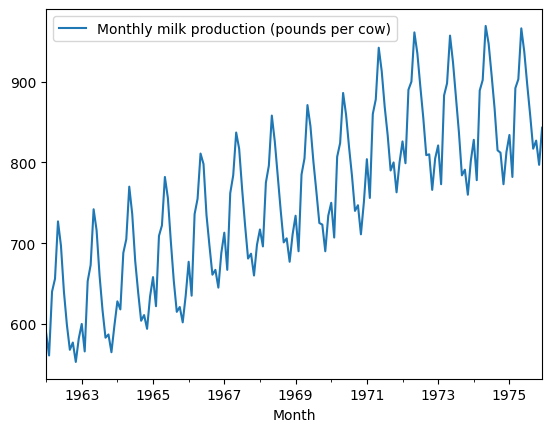

In [36]:
# 4. Plot the time series data
milk.plot()

In [37]:
# train_test_split
# 用前12年的数据作为训练集
# 后1年的数据作为测试集

# 后一年的数据 是12个月，是由循环神经网络1个月1个月的预测出来的

# 5. Perform the train test split on the data

milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Monthly milk production (pounds per cow)  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


In [38]:
# We take the 13 years data for training
train_set = milk.head(156)

# remaining 1 year data for testing

test_set = milk.tail(12)

In [39]:
# 标准化数据
# 6. Scale the data using standard machine learning process
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [40]:
# 7. Define your customized data generator
def next_batch(training_data, batch_size, steps):
    while True:
        # Grab a random starting point for each batch
        rand_start = np.random.randint(0, len(training_data) - steps)
        # Create Y data for time series in the batches
        y_batch = np.array(training_data[rand_start: rand_start + steps + 1]).reshape(1, steps + 1)
        # 分别取 前steps 个 和 后 steps个，其中有 steps -1个重合的
        yield y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [41]:
# 8. Setting up the RNN model
# import tensorflow
import tensorflow as tf

num_inputs = 1
# Num of timesteps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

# You can also try increasing iterations, but decreasing learning rate
# learning_rate you can play with this
learning_rate = 0.03
# how many iterations to go through(training steps), you can play with this
num_train_iterations = 4000
# size of the batch of data
batch_size = 1

In [42]:
# Define your RNN model
class MyRNN(tf.keras.Model):
    def __init__(self, hidden_size, num_outputs):
        super(MyRNN, self).__init__()
        self.rnn_cell = tf.keras.layers.GRU(units=hidden_size, return_sequences=True)
        self.projection_layer = tf.keras.layers.Dense(units=num_outputs)
    
    def call(self, inputs):
        rnn_output = self.rnn_cell(inputs)
        output = self.projection_layer(rnn_output)
        return output

model = MyRNN(num_neurons, num_outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(next_batch(train_scaled, batch_size, num_time_steps), steps_per_epoch=num_train_iterations)

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0133


In [43]:
train_seed = list(train_scaled[-12:].reshape(12))
# 每次用上次产生的1 + 前面的11 接着往后面预测
for iteration in range(12):
    x_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
    y_pred = model.predict(x_batch)
    # 预测出来的最后一个值
    print(y_pred[0,-1, 0])
    # 放到train_seed的最后，参与下一次的预测工作
    train_seed.append(y_pred[0,-1, 0])
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
0.6866021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.64988434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.83964497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.93847454
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1.0676395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1.0125418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.8710143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.702698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.5500839
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.50795764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.46075204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.53885895


In [44]:
train_seed

[0.6610576923076923,
 0.5408653846153846,
 0.8076923076923077,
 0.8389423076923077,
 1.0000000000000002,
 0.9471153846153848,
 0.8533653846153848,
 0.7548076923076923,
 0.6298076923076923,
 0.622596153846154,
 0.528846153846154,
 0.625,
 0.6866021,
 0.64988434,
 0.83964497,
 0.93847454,
 1.0676395,
 1.0125418,
 0.8710143,
 0.702698,
 0.5500839,
 0.50795764,
 0.46075204,
 0.53885895]

In [45]:
# 17. Reshape the results
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12, 1))

In [46]:
results

array([[838.62646],
       [823.35187],
       [902.29224],
       [943.40546],
       [997.13806],
       [974.21735],
       [915.3419 ],
       [845.3223 ],
       [781.83484],
       [764.31036],
       [744.67285],
       [777.16534]], dtype=float32)

In [47]:
test_set['Generated'] = results

/tmp/ipykernel_257/433594325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Generated'] = results


In [48]:
# 查看最终的test_set DataFrame
test_set

,Monthly milk production (pounds per cow),Generated
Month,,
1975-01-01,834,838.626465
1975-02-01,782,823.351868
1975-03-01,892,902.292236
1975-04-01,903,943.405457
1975-05-01,966,997.138062
1975-06-01,937,974.217346
1975-07-01,896,915.341919
1975-08-01,858,845.322327
1975-09-01,817,781.834839


<Axes: xlabel='Month'>

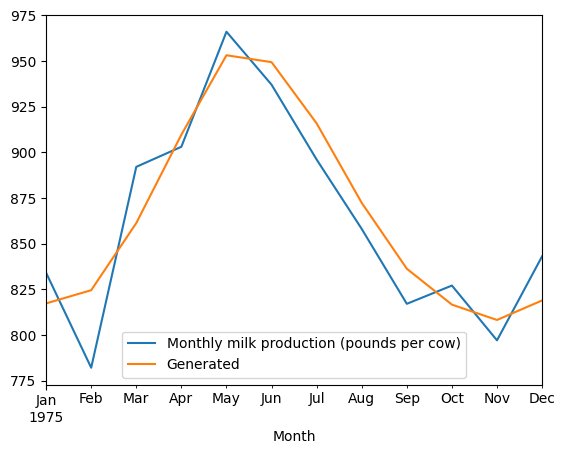

In [32]:
# Plot the predicted result and actual result
test_set.plot()